In [ ]:
# Checking to see if GPU drive is active
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 25 16:04:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Checking to see if GPU drive is active
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# If running in google colab:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [141]:
# Download en_core_web_lg for google colab
# !python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=9b8337af2e4154d05e7d0fa7e471861a7da1447313fcf8d73c2c3e4db75ce167
  Stored in directory: /tmp/pip-ephem-wheel-cache-c3c27ogu/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [200]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import regex as re
# import unicodedata

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.preprocessing import StandardScaler

# KNN used to help determine epsilon value for DBSCAN
from sklearn.neighbors import NearestNeighbors

# import spacy
# import en_core_web_lg
# from spacy.lang.en import English
# from spacy.lang.en.stop_words import STOP_WORDS

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [201]:
# # Loading the large (sm) spaCy English model, pre-trained on web text data
# # In order to use vectorization, you must use the large pipeline package
# # https://spacy.io/usage/spacy-101
# '''
# "To make them compact and fast, spaCy’s small pipeline packages (all packages that end in sm) 
# don’t ship with word vectors, and only include context-sensitive tensors... 
# So in order to use real word vectors, you need to download a larger pipeline package."
# '''
# nlp = en_core_web_lg.load()

# # max length must be increased due to large size of each document
# nlp.max_length = 10000000 # or higher

In [202]:
# # Importing the finalized concatinated dataframe
# # Use this line if running locally
# data = pd.read_csv('../data/tweet_vectors.csv')

# If running in google colab, use this import line:
# Change to file location if necessary
# data = pd.read_csv('/content/drive/MyDrive/Python/tweet_vectors_1.csv')

data1 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_1.json')
data2 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_2.json')
data3 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_3.json')
data4 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_4.json')


In [203]:
data1.head()

,Unnamed: 0,screen_name,state,position,name,party,tweet_count,text_concat,text_length,text_length_1,text_length_2,text_length_3,word_length,text_concat_clean,liststring,vectors
0,0,RepBarragan,CA,Representative,Nanette Diaz Barrag_n,D,4553,So great to welcome SenSanders to CA44 for a r...,1571519,1570974,1570974,1449495,180653,"['great', 'welcome', 'SenSanders', 'CA44', 'ra...",'great' 'welcome' 'SenSanders' 'CA44' 'rally' ...,"[-0.19524726380000001, 0.3918217854, 0.0493305..."
1,1,ChrisMurphyCT,CT,Senator,Christopher Murphy,D,8793,New apartments new businesses and new restaura...,2801192,2800624,2800624,2598814,352609,"['new', 'apartment', 'new', 'business', 'new',...",'new' 'apartment' 'new' 'business' 'new' 'rest...,"[-0.2074928593, 0.3944523199, 0.0484009482, -0..."
2,2,RepSwalwell,CA,Representative,Eric Swalwell,D,5841,Literally the easiest fix we could make to sav...,1843540,1842810,1842810,1704609,223536,"['literally', 'easy', 'fix', 'save', 'life', '...",'literally' 'easy' 'fix' 'save' 'life' 'httpab...,"[-0.2089821815, 0.39251183640000004, 0.0458777..."
3,3,RepDonBeyer,VA,Representative,Donald Beyer Jr,D,18325,9 Baltimore students were killed with guns dur...,7087050,7085835,7085835,6576425,839968,"['Baltimore', 'student', 'kill', 'gun', 'schoo...",'Baltimore' 'student' 'kill' 'gun' 'school' 'y...,"[-0.21396224300000002, 0.3897273741, 0.0522410..."
4,4,WarrenDavidson,OH,Representative,Warren Davidson,R,3166,NetNeutralityReminder Obama used 1934 FCC rule...,958737,958292,958292,886492,112053,"['netneutralityreminder', 'Obama', 'FCC', 'rul...",'netneutralityreminder' 'Obama' 'FCC' 'rule' '...,"[-0.20934589990000002, 0.39374101650000004, 0...."


In [204]:
data = pd.concat([data1, data2, data3, data4], axis=0, sort=False)

# data = data.drop_duplicates()

data.head(3)

,Unnamed: 0,screen_name,state,position,name,party,tweet_count,text_concat,text_length,text_length_1,text_length_2,text_length_3,word_length,text_concat_clean,liststring,vectors
0,0,RepBarragan,CA,Representative,Nanette Diaz Barrag_n,D,4553,So great to welcome SenSanders to CA44 for a r...,1571519,1570974,1570974,1449495,180653,"['great', 'welcome', 'SenSanders', 'CA44', 'ra...",'great' 'welcome' 'SenSanders' 'CA44' 'rally' ...,"[-0.19524726380000001, 0.3918217854, 0.0493305..."
1,1,ChrisMurphyCT,CT,Senator,Christopher Murphy,D,8793,New apartments new businesses and new restaura...,2801192,2800624,2800624,2598814,352609,"['new', 'apartment', 'new', 'business', 'new',...",'new' 'apartment' 'new' 'business' 'new' 'rest...,"[-0.2074928593, 0.3944523199, 0.0484009482, -0..."
2,2,RepSwalwell,CA,Representative,Eric Swalwell,D,5841,Literally the easiest fix we could make to sav...,1843540,1842810,1842810,1704609,223536,"['literally', 'easy', 'fix', 'save', 'life', '...",'literally' 'easy' 'fix' 'save' 'life' 'httpab...,"[-0.2089821815, 0.39251183640000004, 0.0458777..."


In [205]:
# keeping only certain columns that will be used
columns_keep =['screen_name','state','position','name','party','tweet_count','text_concat_clean','liststring','vectors']

data = data[columns_keep]

In [206]:
data.head(3)

,screen_name,state,position,name,party,tweet_count,text_concat_clean,liststring,vectors
0,RepBarragan,CA,Representative,Nanette Diaz Barrag_n,D,4553,"['great', 'welcome', 'SenSanders', 'CA44', 'ra...",'great' 'welcome' 'SenSanders' 'CA44' 'rally' ...,"[-0.19524726380000001, 0.3918217854, 0.0493305..."
1,ChrisMurphyCT,CT,Senator,Christopher Murphy,D,8793,"['new', 'apartment', 'new', 'business', 'new',...",'new' 'apartment' 'new' 'business' 'new' 'rest...,"[-0.2074928593, 0.3944523199, 0.0484009482, -0..."
2,RepSwalwell,CA,Representative,Eric Swalwell,D,5841,"['literally', 'easy', 'fix', 'save', 'life', '...",'literally' 'easy' 'fix' 'save' 'life' 'httpab...,"[-0.2089821815, 0.39251183640000004, 0.0458777..."


In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 151
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   screen_name        623 non-null    object
 1   state              623 non-null    object
 2   position           623 non-null    object
 3   name               623 non-null    object
 4   party              623 non-null    object
 5   tweet_count        623 non-null    int64 
 6   text_concat_clean  623 non-null    object
 7   liststring         623 non-null    object
 8   vectors            623 non-null    object
dtypes: int64(1), object(8)
memory usage: 48.7+ KB


In [208]:
data['vectors'][0][0]

0    [-0.19524726380000001, 0.3918217854, 0.0493305...
0    [-0.1972977185, 0.4062525852, 0.04576505, -0.0...
0    [-0.19127933330000002, 0.386952534, 0.05601444...
0    [-0.19360094890000001, 0.3976558457, 0.0497050...
Name: vectors, dtype: object

In [209]:
len(data['vectors'][5])


4

In [210]:
data.shape

(623, 9)

In [211]:
# Create X
X = data['vectors']
X = np.matrix(X.tolist())

# Applying the Standard Scaler
sc = StandardScaler()

X = sc.fit_transform(X)

In [212]:
X.shape

(623, 300)

In [213]:
# looking at multiple silhouette scores

# set up empty list to store scores
scores = []

for k in range(2, 10):
    # instantiate model
    km = KMeans(n_clusters=k)

    # fit the model
    km.fit(X)

    # Get silhouette score for each k
    sil_score = silhouette_score(X, km.labels_)
    scores.append([k, sil_score])

# save as a df for viewing
scores_df = pd.DataFrame(scores, columns = ['k', 'silhouette'])

# looking at silhouette scores
scores_df

,k,silhouette
0,2,0.140147
1,3,0.141982
2,4,0.091599
3,5,0.083137
4,6,0.076304
5,7,0.057207
6,8,0.055769
7,9,0.061729


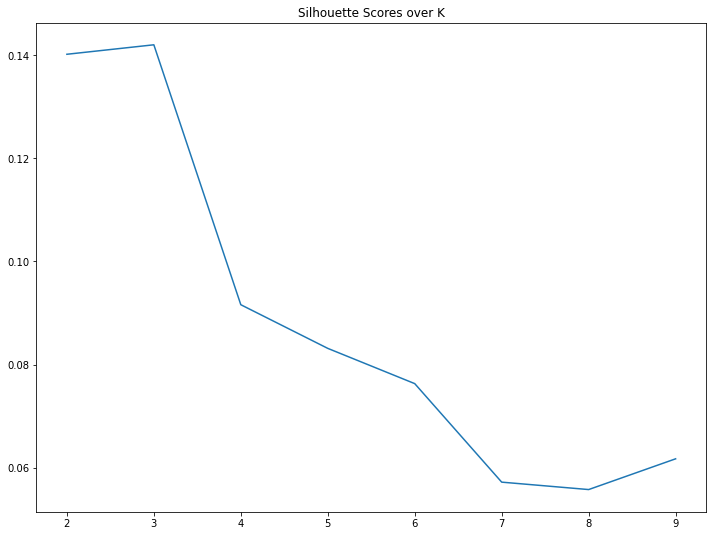

In [214]:
# plotting the silhouette scores across k's

plt.figure(figsize=(12,9))

plt.plot(scores_df['k'], scores_df['silhouette'])

plt.title('Silhouette Scores over K')

plt.show()

In [215]:
# looking at multiple inertia scores

# set up empty list to store scores
scores = []

for k in range(2, 10):

    # instantiate model
    km = KMeans(n_clusters=k)

    # fit the model
    km.fit(X)

    # Get inertia score for each k
    scores.append([k, km.inertia_])

# save as a df for viewing
scores_df = pd.DataFrame(scores, columns = ['k', 'inertia'])

# looking at silhouette scores
scores_df

,k,inertia
0,2,163032.451478
1,3,146479.958091
2,4,137427.866841
3,5,131881.505014
4,6,128063.915475
5,7,125101.131981
6,8,121159.930271
7,9,118259.365823


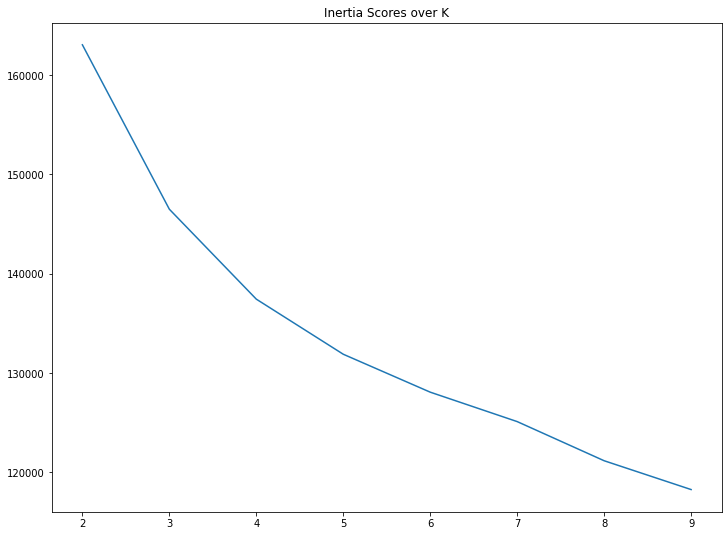

In [216]:
# plotting the inertia scores across k's
# Using the 'elbow' method to help find a good k
# https://medium.com/@cmukesh8688/k-means-clustering-in-machine-learning-252130c85e23

plt.figure(figsize=(12,9))

plt.plot(scores_df['k'], scores_df['inertia'])

plt.title('Inertia Scores over K')

plt.show()

In [217]:

# # Instantiate and fit a gridsearch for a KMeans clustering model
# km = KMeans()

# params = {
#     'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9] #, 10] #, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#     # 'n_clusters': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
   
# }

# gs = GridSearchCV(km, params, cv=5, verbose=1)
# gs.fit(X)

# # Get the best estimator
# print(gs.best_estimator_)
# print('-----------------')
# print(silhouette_score(X, gs.best_estimator_.labels_))

In [218]:
# # Create new column with KMeans labels and look at distribution of labels
# data['km_labels'] = gs.best_estimator_.labels_
# data['km_labels'].value_counts()

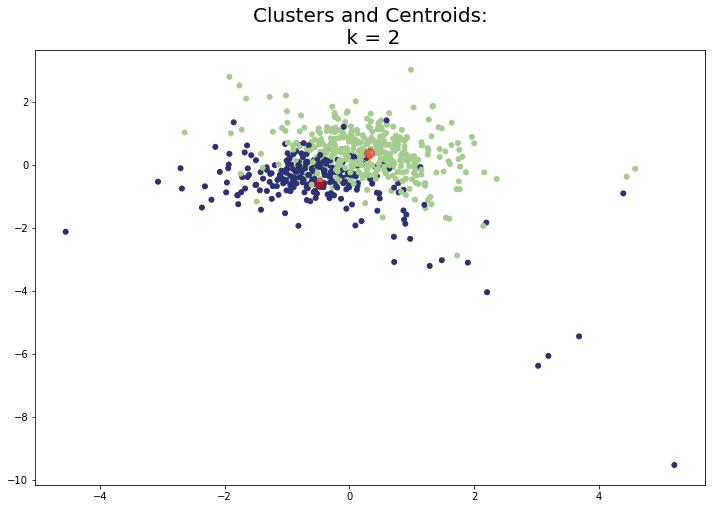

In [219]:
# from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(X)
km_means = km.predict(X)

plt.figure(figsize=(12,8))

plt.scatter([X[:, 0]], [X[:, 1]], c=km_means, s=25, cmap='crest')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)

plt.title('Clusters and Centroids:\n k = 2', size=20)
plt.show()

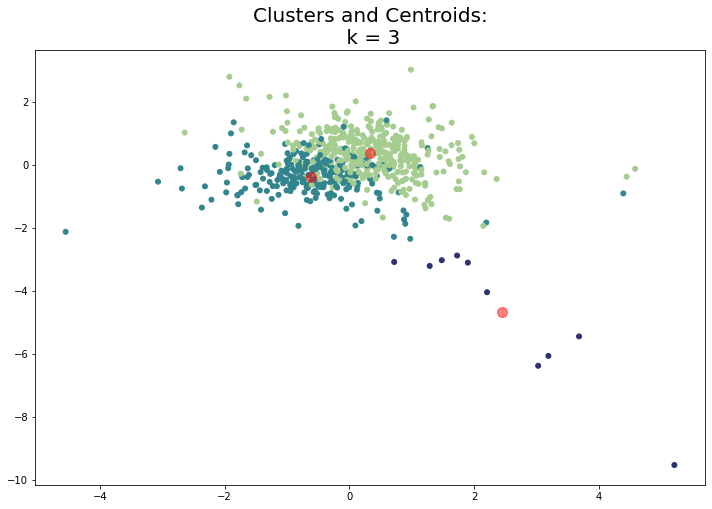

In [220]:
# from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(X)
km_means = km.predict(X)

plt.figure(figsize=(12,8))

plt.scatter([X[:, 0]], [X[:, 1]], c=km_means, s=25, cmap='crest')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)

plt.title('Clusters and Centroids:\n k = 3', size=20)
plt.show()

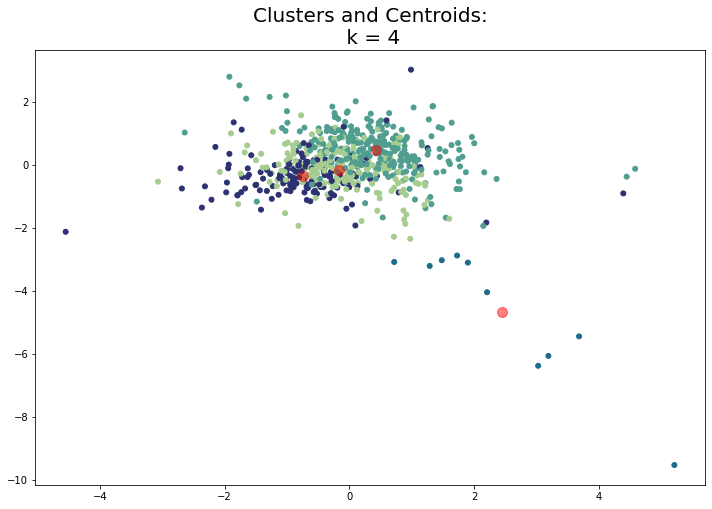

In [221]:
# from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
km.fit(X)
km_means = km.predict(X)

plt.figure(figsize=(12,8))

plt.scatter([X[:, 0]], [X[:, 1]], c=km_means, s=25, cmap='crest')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)

plt.title('Clusters and Centroids:\n k = 4', size=20)
plt.show()

In [222]:
# Based on above information, fitting with 3 clusters

km = KMeans(n_clusters = 3, random_state=516)

km.fit(X)

# print(km.cluster_centers_)

# adding km labels back on the dataframe
data['km_label'] = km.labels_

data.head(3)

,screen_name,state,position,name,party,tweet_count,text_concat_clean,liststring,vectors,km_label
0,RepBarragan,CA,Representative,Nanette Diaz Barrag_n,D,4553,"['great', 'welcome', 'SenSanders', 'CA44', 'ra...",'great' 'welcome' 'SenSanders' 'CA44' 'rally' ...,"[-0.19524726380000001, 0.3918217854, 0.0493305...",1
1,ChrisMurphyCT,CT,Senator,Christopher Murphy,D,8793,"['new', 'apartment', 'new', 'business', 'new',...",'new' 'apartment' 'new' 'business' 'new' 'rest...,"[-0.2074928593, 0.3944523199, 0.0484009482, -0...",0
2,RepSwalwell,CA,Representative,Eric Swalwell,D,5841,"['literally', 'easy', 'fix', 'save', 'life', '...",'literally' 'easy' 'fix' 'save' 'life' 'httpab...,"[-0.2089821815, 0.39251183640000004, 0.0458777...",0


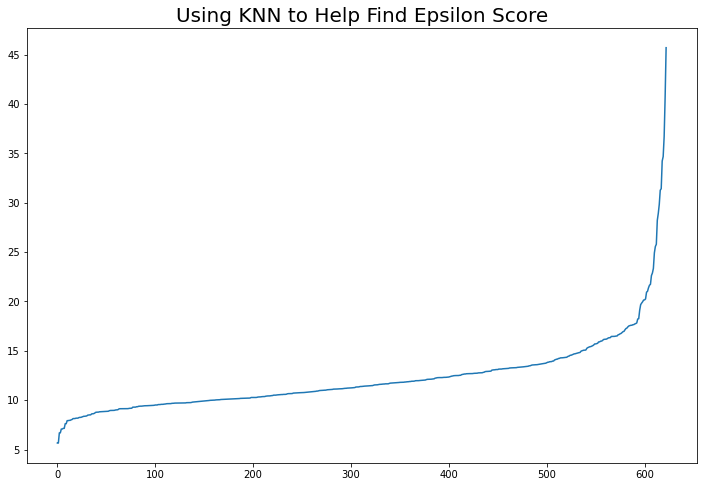

In [223]:
# Using KNN to help find a good epsilon score
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

k_neighbors = NearestNeighbors(n_neighbors=5)

k_nbrs = k_neighbors.fit(X)

distances, indices = k_nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)

distances = distances[:,1]

plt.figure(figsize=(12,8))

plt.plot(distances)

plt.title('Using KNN to Help Find Epsilon Score', size=20)

plt.show()

In [224]:
# Trying DBSCAN using the epsilon found above

dbscan = DBSCAN(eps=18, min_samples=8) #change the epsilon

dbscan.fit(X)

print(set(dbscan.labels_))

print(silhouette_score(X, dbscan.labels_))

print('--------------------')

data['dbscan_label'] = dbscan.labels_

print(data['dbscan_label'].value_counts())

print('--------------------')

data.head(3)

{0, -1}
0.40258354186293815
--------------------
 0    589
-1     34
Name: dbscan_label, dtype: int64
--------------------


,screen_name,state,position,name,party,tweet_count,text_concat_clean,liststring,vectors,km_label,dbscan_label
0,RepBarragan,CA,Representative,Nanette Diaz Barrag_n,D,4553,"['great', 'welcome', 'SenSanders', 'CA44', 'ra...",'great' 'welcome' 'SenSanders' 'CA44' 'rally' ...,"[-0.19524726380000001, 0.3918217854, 0.0493305...",1,0
1,ChrisMurphyCT,CT,Senator,Christopher Murphy,D,8793,"['new', 'apartment', 'new', 'business', 'new',...",'new' 'apartment' 'new' 'business' 'new' 'rest...,"[-0.2074928593, 0.3944523199, 0.0484009482, -0...",0,0
2,RepSwalwell,CA,Representative,Eric Swalwell,D,5841,"['literally', 'easy', 'fix', 'save', 'life', '...",'literally' 'easy' 'fix' 'save' 'life' 'httpab...,"[-0.2089821815, 0.39251183640000004, 0.0458777...",0,0


In [232]:

# Get the cosine similarity for each document
# Help from Kelly Slatery
# Looking at the first 50 documents
vector_distances = pd.DataFrame(pairwise_distances(X[:50], X[:50], metric='cosine'))
vector_distances.corr().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.000000,-0.054284,0.115981,0.065791,-0.045132,0.302493,-0.405994,0.028965,0.549515,0.334265,-0.178641,0.083451,0.071528,0.120234,-0.507347,0.524552,0.450538,0.075838,-0.311259,0.311982,0.124266,-0.060141,0.144376,0.174284,-0.428840,0.629586,0.041531,-0.158303,-0.206516,0.389820,0.223527,-0.414026,-0.263395,-0.280311,-0.449596,-0.060954,-0.638539,0.138205,-0.391537,-0.005763,0.292629,0.432572,-0.490778,0.788191,-0.353281,-0.067717,0.685351,-0.611830,0.441230,-0.263916
1,-0.054284,1.000000,0.950631,0.886909,0.824023,0.547562,-0.710871,-0.755169,-0.021341,0.833469,-0.859287,-0.006557,0.792299,0.593868,-0.697718,0.612969,-0.477948,0.882252,-0.608284,0.713002,-0.599515,0.687813,-0.810417,0.056330,0.560138,0.343683,0.459138,0.738018,-0.689096,0.286949,0.858452,-0.603850,-0.238486,-0.751389,-0.617328,0.722006,-0.267098,-0.780161,-0.736433,-0.523440,0.672955,0.511039,0.231257,0.345927,-0.688222,-0.829542,-0.490982,-0.530232,-0.252945,-0.723318
2,0.115981,0.950631,1.000000,0.896393,0.814140,0.575589,-0.800488,-0.774266,0.080314,0.891366,-0.875189,0.055152,0.854487,0.501548,-0.834187,0.708113,-0.436566,0.959874,-0.710301,0.816077,-0.611195,0.728194,-0.725214,-0.034335,0.578355,0.423144,0.346640,0.732501,-0.787604,0.356339,0.883097,-0.718997,-0.252645,-0.747463,-0.701037,0.638929,-0.404832,-0.789617,-0.801538,-0.608864,0.769359,0.574822,0.099765,0.477219,-0.751905,-0.819745,-0.400344,-0.651816,-0.131973,-0.794340
3,0.065791,0.886909,0.896393,1.000000,0.912178,0.775191,-0.855492,-0.646915,0.125266,0.858418,-0.786499,-0.221788,0.873577,0.702736,-0.718165,0.792419,-0.417589,0.887639,-0.598527,0.917854,-0.613622,0.432248,-0.839122,0.070670,0.444760,0.460822,0.370244,0.783897,-0.746456,0.156519,0.774612,-0.802134,-0.318323,-0.797567,-0.488896,0.865640,-0.568682,-0.525808,-0.778166,-0.316456,0.864455,0.607442,-0.096076,0.562567,-0.868083,-0.948691,-0.319894,-0.704069,-0.278836,-0.848073
4,-0.045132,0.824023,0.814140,0.912178,1.000000,0.802077,-0.815447,-0.548308,0.083675,0.846455,-0.833507,-0.039241,0.883761,0.759740,-0.581611,0.749118,-0.484162,0.789108,-0.630964,0.821031,-0.768660,0.374774,-0.751156,0.008962,0.355511,0.470781,0.446925,0.654837,-0.812673,0.153252,0.728550,-0.807563,-0.135012,-0.622061,-0.532962,0.847065,-0.453441,-0.541257,-0.712198,-0.216362,0.846833,0.629675,-0.061002,0.475469,-0.867370,-0.909717,-0.300061,-0.629957,-0.346483,-0.755037


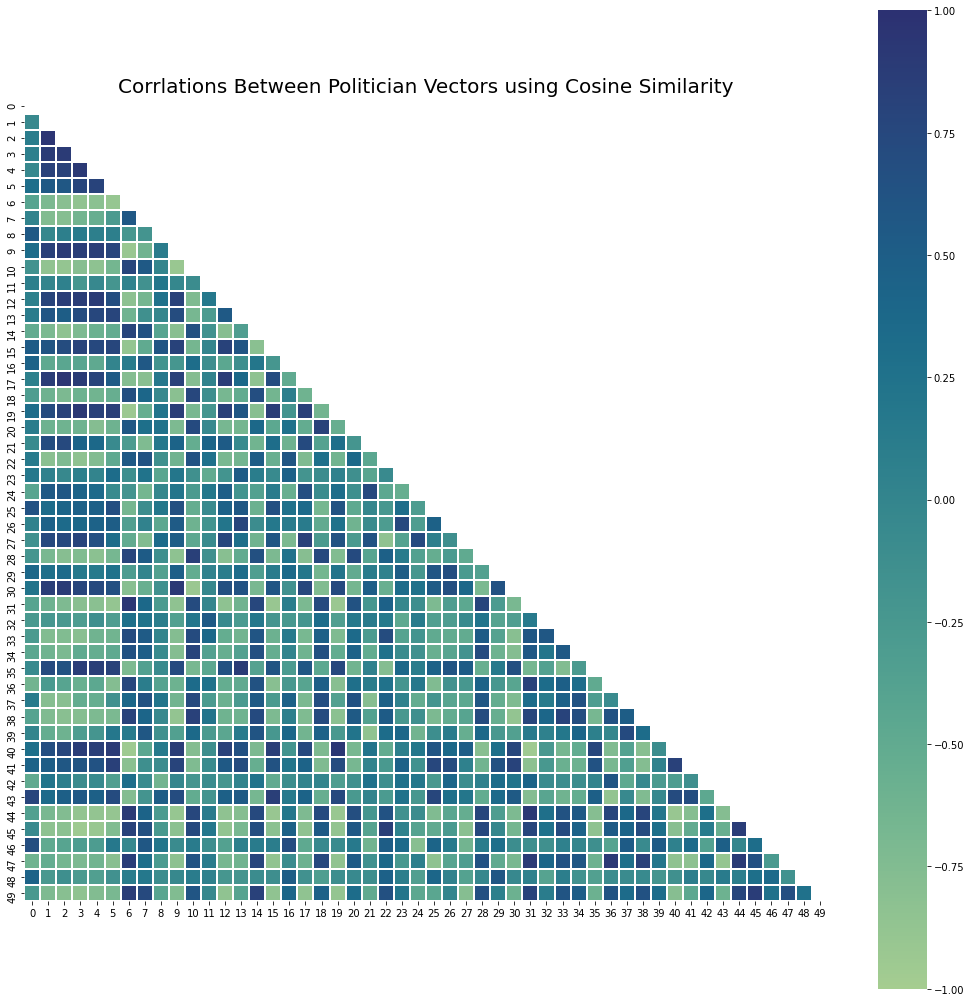

In [238]:
# Seeing correlations between first 50 documents (dataset is too large with all documents) using cosine similarity
plt.figure(figsize=(18,18))

corr = vector_distances.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            cmap='crest', 
            vmax=1, 
            vmin=-1, 
            linecolor='white', 
            linewidths=1,
            square=True, 
           mask=mask)

plt.title('Corrlations Between Politician Vectors using Cosine Similarity', size=20)

plt.show()

In [239]:

# # Export dataframe with kmeans and dbscan labels
# data.to_csv('./data/vectors_labels_df.csv', index=False)

# Exporting in google colab. Update directory as needed.
data.to_csv('/content/drive/MyDrive/Python/vectors_labels_df.csv', index=False)
